In [5]:
# Check jupyter or not
from IPython import get_ipython
def type_of_script():
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str: return 'jupyter'
        if 'terminal' in ipy_str: return 'ipython'
    except: return 'terminal'
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm

# Default libraries
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from matplotlib.colors import Normalize
import cmasher as cmr
import numpy as np
import os, glob, atexit, signal, time, warnings
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# rur package
from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0

# Custom package
from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from common_func import *
from ramses_function import *

# Python Argument Parser
# print("ex: $ python3 06c_stable_tree.py [--mod 7]")
# import argparse
# parser = argparse.ArgumentParser(description='(syj3514@yonsei.ac.kr)')
# parser.add_argument("-m", "--mod", required=True, help='mod', type=int)
# args = parser.parse_args()
# mod = args.mod

In [6]:
ncpu=48
home = '/home/jeon'
if(not os.path.isdir(home)): home = '/gem_home/jeon'

In [7]:
mode1 = 'nh'; database1 = f"{home}/MissingSat/database/{mode1}"
iout1 = 1026; repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1); snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
# gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
# hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1, allsubs1, states1, dinks1, pairs1, upairs1 = extract_from_LG(LG1)
print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [8]:
mode2 = 'nh2'; database2 = f"{home}/MissingSat/database/{mode2}"
iout2 = 797; repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2); snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
# gals1 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
# hals1 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2, allsubs2, states2, dinks2, pairs2, upairs2 = extract_from_LG(LG2)
print(len(allsubs2), np.unique(states2, return_counts=True))  

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [9]:
stree1 = pklload(f"{database1}/stable_tree_new.pickle")
rtree1 = pklload(f"{database1}/stable_tree_raw.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [10]:
stree2 = pklload(f"{database2}/stable_tree_new.pickle")
rtree2 = pklload(f"{database2}/stable_tree_raw.pickle")
print(stree2[list(stree2.keys())[0]].dtype.names)

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


# Insitu Example

## NH Check

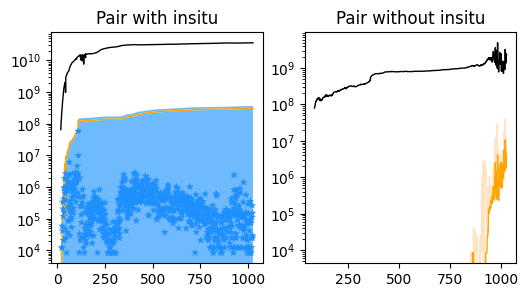

In [11]:
case1 = 0 # Pair with insitu
case2 = 0 # Pair without insitu
fig, axes = plt.subplots(ncols=2, figsize=(6,3))
for pair in pairs1:
    branch = stree1[pair['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu)and(case1==0):
        ax = axes[0]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("Pair with insitu")
        case1 = 1
    if(not True in insitu)and(case2==0):
        ax = axes[1]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("Pair without insitu")
        case2 = 1
    if(case1>0)and(case2>0): break
plt.show(); plt.close()

2119


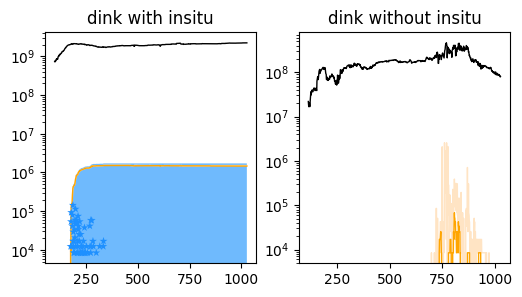

In [12]:
case1 = 0 # Dink with insitu
case2 = 0 # Dink without insitu
fig, axes = plt.subplots(ncols=2, figsize=(6,3))
for dink in dinks1:
    branch = stree1[dink['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu)and(case1==0):
        print(dink['id'])
        ax = axes[0]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("dink with insitu")
        case1 = 1
    if(not True in insitu)and(case2==0):
        ax = axes[1]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("dink without insitu")
        case2 = 1
    if(case1>0)and(case2>0): break
plt.show(); plt.close()

In [13]:
print(f"All {len(allsubs1)}")
counts = [0,0,0,0]
for sub in allsubs1:
    i = 0 if(~sub['dink']) else 1
    branch = stree1[sub['id']]
    j = 0 if(branch['insitu_vir']>0).any() else 1
    counts[2*i + j] += 1
print(f"Pair w/  insitu: {counts[0]}")
print(f"Pair w/o insitu: {counts[1]}")
print(f"Dink w/  insitu: {counts[2]}")
print(f"Dink w/o insitu: {counts[3]}")

All 1336
Pair w/  insitu: 149
Pair w/o insitu: 42
Dink w/  insitu: 126
Dink w/o insitu: 1019


## NH2 Check

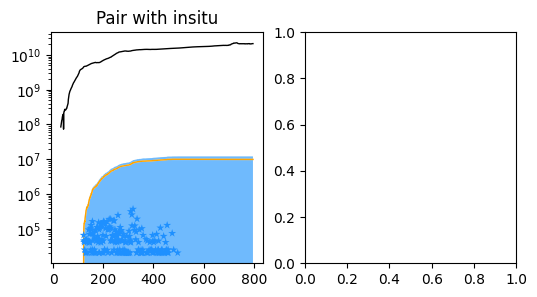

In [14]:
case1 = 0 # Pair with insitu
case2 = 0 # Pair without insitu
fig, axes = plt.subplots(ncols=2, figsize=(6,3))
for pair in pairs2:
    branch = stree2[pair['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu)and(case1==0):
        ax = axes[0]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("Pair with insitu")
        case1 = 1
    if(not True in insitu)and(case2==0):
        ax = axes[1]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("Pair without insitu")
        case2 = 1
    if(case1>0)and(case2>0): break
plt.show(); plt.close()

3402


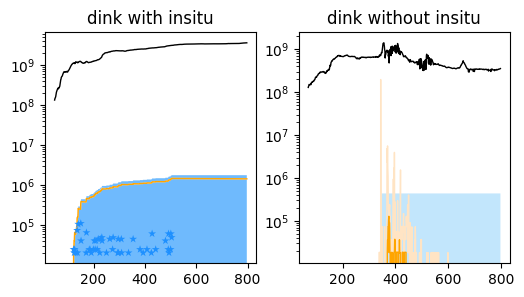

In [15]:
case1 = 0 # Dink with insitu
case2 = 0 # Dink without insitu
fig, axes = plt.subplots(ncols=2, figsize=(6,3))
for dink in dinks2:
    branch = stree2[dink['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu)and(case1==0):
        print(dink['id'])
        ax = axes[0]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("dink with insitu")
        case1 = 1
    if(np.sum(insitu)==0)and(case2==0):
        ax = axes[1]
        ax.plot(branch['timestep'], branch['mdm_vir'], c='k', lw=1)
        ax.plot(branch['timestep'], branch['mstar'], c='bisque', lw=1)
        ax.plot(branch['timestep'], branch['mstar_vir'], c='orange', lw=1)
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue', marker='*', ec='none', zorder=3)
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu'][::-1])[::-1], fc='lightskyblue', alpha=0.5, ec='none')
        ax.fill_between(branch['timestep'], np.full(len(branch), 0), np.cumsum(branch['insitu_vir'][::-1])[::-1], fc='dodgerblue', alpha=0.5, ec='none')
                
        ax.set_yscale('log')
        ax.set_title("dink without insitu")
        case2 = 1
    if(case1>0)and(case2>0): break
plt.show(); plt.close()

In [16]:
print(f"All {len(allsubs2)}")
counts = [0,0,0,0]
for sub in allsubs2:
    i = 0 if(~sub['dink']) else 1
    branch = stree2[sub['id']]
    j = 0 if(branch['insitu_vir']>0).any() else 1
    counts[2*i + j] += 1
print(f"Pair w/  insitu: {counts[0]}")
print(f"Pair w/o insitu: {counts[1]}")
print(f"Dink w/  insitu: {counts[2]}")
print(f"Dink w/o insitu: {counts[3]}")

All 1242
Pair w/  insitu: 105
Pair w/o insitu: 17
Dink w/  insitu: 149
Dink w/o insitu: 971


# Record First SF

## NH

In [480]:
first_SF = np.zeros((len(allsubs1), 2), dtype=np.int32)-1
for i, sub in enumerate(allsubs1):
    first_SF[i, 0] = sub['id']
    branch = stree1[sub['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu):
        first = branch[insitu][-1]
        first_SF[i, 1] = first['timestep']
first_SF

array([[  693,    -1],
       [ 1309,    -1],
       [ 1310,    -1],
       ...,
       [28532,    -1],
       [28581,    -1],
       [28582,    -1]], dtype=int32)

In [496]:
tmp = {}
for iid, iout in tqdm(first_SF):
    if(iout<0): continue
    where = np.where(nout1==iout)[0][0]
    iouts = nout1[max(0,where-10):where+11]
    for iout in iouts:
        if(not iout in tmp.keys()):
            tmp[iout] = []
        tmp[iout].append(iid)
letsfind = dict(sorted(tmp.items()))
pklsave(letsfind, f"{database1}/SF/finddict.pickle")

  0%|          | 0/1336 [00:00<?, ?it/s]

## NH2

In [497]:
first_SF = np.zeros((len(allsubs2), 2), dtype=np.int32)-1
for i, sub in enumerate(allsubs2):
    first_SF[i, 0] = sub['id']
    branch = stree2[sub['id']]
    insitu = branch['insitu_vir']>0
    if(True in insitu):
        first = branch[insitu][-1]
        first_SF[i, 1] = first['timestep']
first_SF

array([[  644,    -1],
       [ 1529,    -1],
       [ 1577,    -1],
       ...,
       [28895,    -1],
       [28896,    -1],
       [28899,    -1]], dtype=int32)

In [504]:
tmp = {}
for iid, iout in tqdm(first_SF):
    if(iout<0): continue
    where = np.where(nout2==iout)[0][0]
    iouts = nout2[max(0,where-10):where+11]
    for iout in iouts:
        if(not iout in tmp.keys()):
            tmp[iout] = []
        tmp[iout].append(iid)
letsfind = dict(sorted(tmp.items()))
pklsave(letsfind, f"{database2}/SF/finddict.pickle")

  0%|          | 0/1242 [00:00<?, ?it/s]

In [508]:
n = 0
for key, item in letsfind.items():
    n+= len(item)
n, len(letsfind.keys())

(5334, 743)